In [1]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime

## Functions

In [2]:
def find_model(start, filename):
    for root, dirs, files in os.walk(start):
        if filename in files:
            return os.path.join(root, filename)

In [3]:
start_dir = 'ChemE 546/Project'
file_model = 'multi_enzyme_model.txt'
file_path = find_model(start_dir, file_model)

In [4]:
print(file_path)

None


In [5]:
'''
# Load file and convert to SBML (if not already)
def load_model(filename, filetype): 
    """ Input the filename/path of the file, and its syntax.
    Output declares whether file was successfully loaded or not"""
    
    model_ant = "multi_enzyme_model.txt"
    with open(model_ant, "r") as file:
        model_content = file.read()

    try:
        model_sbml = te.antimonyToSBML(model_content)
        model_load = te.loadSBMLModel(model_sbml)
        print("Successfully loaded file.")
    except Exception as e:
        print("Could not load file.", e)
'''

'\n# Load file and convert to SBML (if not already)\ndef load_model(filename, filetype): \n    """ Input the filename/path of the file, and its syntax.\n    Output declares whether file was successfully loaded or not"""\n    \n    model_ant = "multi_enzyme_model.txt"\n    with open(model_ant, "r") as file:\n        model_content = file.read()\n\n    try:\n        model_sbml = te.antimonyToSBML(model_content)\n        model_load = te.loadSBMLModel(model_sbml)\n        print("Successfully loaded file.")\n    except Exception as e:\n        print("Could not load file.", e)\n'

In [6]:
# Load file and convert to SBML
# If file is in SBML, function will still load the model

def load_model(filename, filetype): 
    """ 
    filename: .txt, .csv, biomodels website
    filetype: ant, sbml
    
    Input the filename/path of the file, and its syntax.
    Output declares whether file was successfully loaded or not
    """
    model_ant = filename
    with open(model_ant, "r") as file:
        model_content = file.read()
    if filetype=='antimony':
        try:
            model_sbml = te.antimonyToSBML(model_content)
            model_load = te.loadSBMLModel(model_sbml)
            print(f"Successfully converted file '{filename}' from {filetype} to SBML and loaded.")
        except Exception as e:
            print("Could not load file.", e)
    else: 
        try:
            model_load = te.loadSBMLModel(model_content)
            print(f"Successfully loaded SBML file {filename}.")
        except Exception as e:
            print("Could not load SBML file.", e)
            
    return model_load

In [16]:
def simulate_model(model, t0, t1, steps):
    # load SBML model into tellurium
    r = te.loadSBMLModel(model)
    
    # simulate based on time interval and time steps
    result = r.simulate(t0, t1, steps) 
    
    # Convert to DataFrame
    species_names = r.getFloatingSpeciesIds()
    columns = ['Time'] + [str(i) for i in species_names]
    df = pd.DataFrame(data=result, columns=columns)
    
    return r, result, df, species_names

In [9]:
def export_csv(model):
    # Grab current time and date, make variable to display date
    now = datetime.now()
    current_time = now.strftime("%Y%m%d_%H.%M.%S")
    
    # Save DataFrame to .csv
    model.to_csv(current_time + ' simulation_data.csv', index=False)
    
    return

In [36]:
# Plot specific species from a model simulation for comparison
def compare_species_plot(dataframe, species_list):
    for species in species_list:
        plt.plot(dataframe['Time'], dataframe[species])
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend(species_list, fontsize = 'x-small', bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
# Plot all species from a model simulation
def all_species_plot(dataframe):
    for species in species_names:
        plt.plot(dataframe['Time'], dataframe[species])
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend(species_names)
    plt.show()

## Testing

In [28]:
# Load model
model = load_model('multi_enzyme_model.txt', 'antimony')

Successfully converted file 'multi_enzyme_model.txt' from antimony to SBML and loaded.


In [27]:
# Simulate and assign variables
r, result, df, species_names = simulate_model(model, 0, 50, 101)

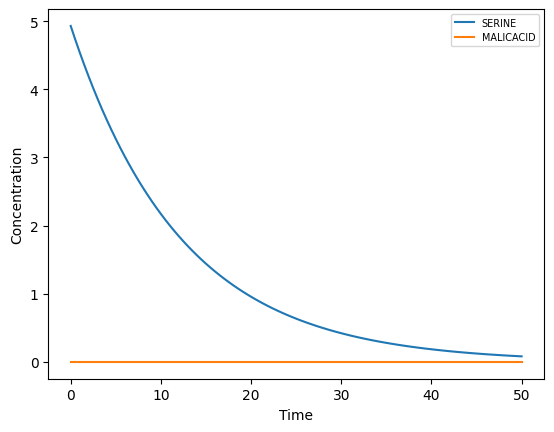

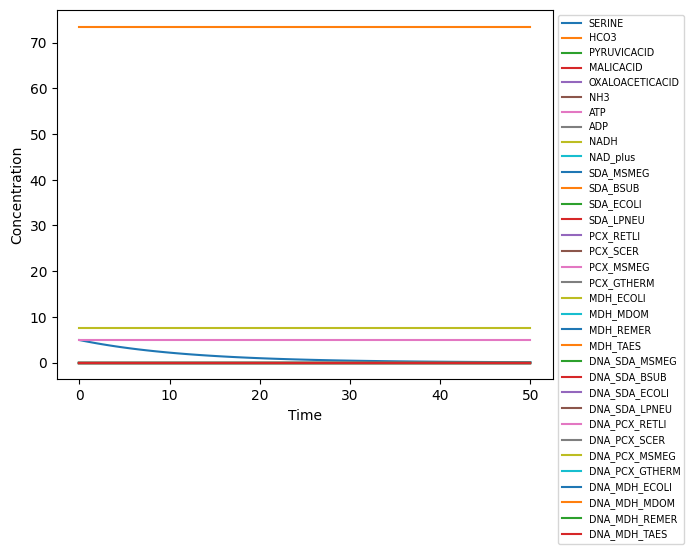

In [37]:
# Extract time and species data
time = df['Time'].values
species_data = df.iloc[:, 1:]

# Specify the subset of species to plot
# This list will have to be generated with the GUI such that each species selected gets appended.
species_list = ['SERINE', 'MALICACID']

#Plots
compare_species_plot(df, species_list)
compare_species_plot(df, species_names)